<a href="https://colab.research.google.com/github/natomendes/transfer-learning-with-fine-tuning/blob/main/transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALAÇÃO E IMPORTAÇÃO DAS BIBLIOTECAS

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import requests
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
import random
from PIL import Image

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.18.0
Keras version: 3.8.0


DOWNLOAD E PREPARAÇÃO DO DATASET

In [2]:
def download_and_extract_dataset():
    """
    Download do dataset Cats vs Dogs da Microsoft e extração dos arquivos
    """
    # URL do dataset
    url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

    # Nome do arquivo
    filename = "kagglecatsanddogs_5340.zip"

    print("Iniciando download do dataset...")

    # Download do arquivo
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as file:
        downloaded = 0
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    percent = (downloaded / total_size) * 100
                    print(f"\rProgress: {percent:.1f}%", end='')

    print(f"\nDownload concluído! Arquivo salvo como: {filename}")

    # Extração do arquivo
    print("Extraindo arquivos...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()

    print("Extração concluída!")

    # Verificar estrutura dos diretórios
    base_dir = 'PetImages'
    cat_dir = os.path.join(base_dir, 'Cat')
    dog_dir = os.path.join(base_dir, 'Dog')

    print(f"Total de imagens de gatos: {len(os.listdir(cat_dir))}")
    print(f"Total de imagens de cachorros: {len(os.listdir(dog_dir))}")

    return base_dir

# Executar download (descomente a linha abaixo na primeira execução)
base_dir = download_and_extract_dataset()

# Para execuções subsequentes, apenas defina o diretório base:
# base_dir = 'PetImages'

Iniciando download do dataset...
Progress: 100.0%
Download concluído! Arquivo salvo como: kagglecatsanddogs_5340.zip
Extraindo arquivos...
Extração concluída!
Total de imagens de gatos: 12501
Total de imagens de cachorros: 12501


In [47]:
def definitive_clean_for_grayscale(base_dir):
    """
    Scans a directory using TensorFlow's grayscale decoder and removes
    any file that causes an error. This is the most reliable cleaning method.
    """
    print(f"--- Starting Definitive Grayscale Scan on {base_dir} ---")
    removed_count = 0
    for folder_name in ("Cat", "Dog"):
        class_dir = os.path.join(base_dir, folder_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory not found: {class_dir}")
            continue

        print(f"Scanning folder: {class_dir}")
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            try:
                # This is the crucial part:
                # 1. Read the file into memory as bytes.
                img_bytes = tf.io.read_file(file_path)
                # 2. Try to decode it with 1 channel (grayscale), just like the training pipeline will.
                tf.io.decode_image(img_bytes, channels=1)

            except tf.errors.InvalidArgumentError:
                # This catches the exact error you are seeing.
                print(f"DELETING corrupted file: {file_path}")
                os.remove(file_path)
                removed_count += 1
            except Exception as e:
                # Catch any other unexpected errors
                print(f"Skipping file with other error {file_path}: {e}")

    print(f"\n--- Scan Complete. Removed {removed_count} incompatible files. ---")

# IMPORTANT: Run this on your main, original dataset folder
base_dir = 'PetImages'
definitive_clean_for_grayscale(base_dir)

--- Starting Definitive Grayscale Scan on PetImages ---
Scanning folder: PetImages/Cat
DELETING corrupted file: PetImages/Cat/8470.jpg
DELETING corrupted file: PetImages/Cat/11874.jpg
DELETING corrupted file: PetImages/Cat/11565.jpg
DELETING corrupted file: PetImages/Cat/3161.jpg
DELETING corrupted file: PetImages/Cat/9565.jpg
DELETING corrupted file: PetImages/Cat/9100.jpg
DELETING corrupted file: PetImages/Cat/10874.jpg
DELETING corrupted file: PetImages/Cat/1267.jpg
DELETING corrupted file: PetImages/Cat/4000.jpg
DELETING corrupted file: PetImages/Cat/10073.jpg
DELETING corrupted file: PetImages/Cat/5819.jpg
DELETING corrupted file: PetImages/Cat/9778.jpg
DELETING corrupted file: PetImages/Cat/11086.jpg
DELETING corrupted file: PetImages/Cat/850.jpg
DELETING corrupted file: PetImages/Cat/5614.jpg
DELETING corrupted file: PetImages/Cat/7642.jpg
DELETING corrupted file: PetImages/Cat/1936.jpg
DELETING corrupted file: PetImages/Cat/2742.jpg
DELETING corrupted file: PetImages/Cat/11729.

ORGANIZAÇÃO DOS DADOS EM TREINO E VALIDAÇÃO

In [48]:
def organize_dataset_and_clean(base_dir, train_ratio=0.8, max_images_per_class=2000):
    """
    Organizes the dataset and cleans it by finding and removing corrupted images
    from the source directory.
    """
    train_dir = 'train'
    validation_dir = 'validation'

    # Remove and recreate train/validation directories
    for directory in [train_dir, validation_dir]:
        if os.path.exists(directory):
            shutil.rmtree(directory)
    os.makedirs(os.path.join(train_dir, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'dogs'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, 'dogs'), exist_ok=True)

    def copy_and_clean_files(source_dir, dest_train, dest_val, class_name):
        """Inner function to process files for a single class."""
        files = os.listdir(source_dir)
        valid_files = []

        print(f"Scanning and cleaning {class_name} images in {source_dir}...")
        for file in files:
            img_path = os.path.join(source_dir, file)
            try:
                # Attempt to open and verify the image file
                img = Image.open(img_path)
                img.verify() # Verifies image integrity. Throws an exception if corrupt.
                valid_files.append(file)
            except Exception as e:
                # --- THIS IS THE MODIFIED PART ---
                # If the file is corrupt, print a message and remove it.
                print(f"Found and removing corrupted file: {img_path} | Reason: {e}")
                try:
                    os.remove(img_path)
                except OSError as remove_error:
                    print(f"Error trying to remove {img_path}: {remove_error}")
                # --- END OF MODIFICATION ---

        # Proceed with the limited, shuffled valid files
        random.shuffle(valid_files)
        limited_files = valid_files[:max_images_per_class]

        split_idx = int(len(limited_files) * train_ratio)
        train_files = limited_files[:split_idx]
        val_files = limited_files[split_idx:]

        # Copy files to train and validation directories
        for file in train_files:
            shutil.copy2(os.path.join(source_dir, file), os.path.join(dest_train, file))
        for file in val_files:
            shutil.copy2(os.path.join(source_dir, file), os.path.join(dest_val, file))

        print(f"{class_name}: {len(train_files)} train, {len(val_files)} validation")

    print(f"Organizing dataset with a max of {max_images_per_class} images per class...")
    # Process cats
    copy_and_clean_files(os.path.join(base_dir, 'Cat'), os.path.join(train_dir, 'cats'),
                         os.path.join(validation_dir, 'cats'), 'Cats')
    # Process dogs
    copy_and_clean_files(os.path.join(base_dir, 'Dog'), os.path.join(train_dir, 'dogs'),
                         os.path.join(validation_dir, 'dogs'), 'Dogs')

    return train_dir, validation_dir

# --- HOW TO USE IT ---
# base_dir = 'PetImages'
# Call this function ONCE to clean your source data and create the train/val sets.
train_dir, validation_dir = organize_dataset_and_clean(base_dir, max_images_per_class=2000)

# For all subsequent runs, just define the paths to avoid re-running the process:
# train_dir = 'train'
# validation_dir = 'validation'

Organizing dataset with a max of 2000 images per class...
Scanning and cleaning Cats images in PetImages/Cat...
Cats: 1600 train, 400 validation
Scanning and cleaning Dogs images in PetImages/Dog...
Dogs: 1600 train, 400 validation


CONFIGURAÇÃO DOS GERADORES DE DADOS

In [49]:
# Parâmetros
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32# --- NEW AND IMPROVED DATA PIPELINE ---
AUTOTUNE = tf.data.AUTOTUNE

# Create the datasets using the modern utility
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# Optimize for performance
print("Optimizing data pipelines...")
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Data pipelines are ready! 🚀")

Found 3200 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Optimizing data pipelines...
Data pipelines are ready! 🚀


VISUALIZAÇÃO DE ALGUMAS IMAGENS DO DATASET

Exemplos de imagens do dataset:


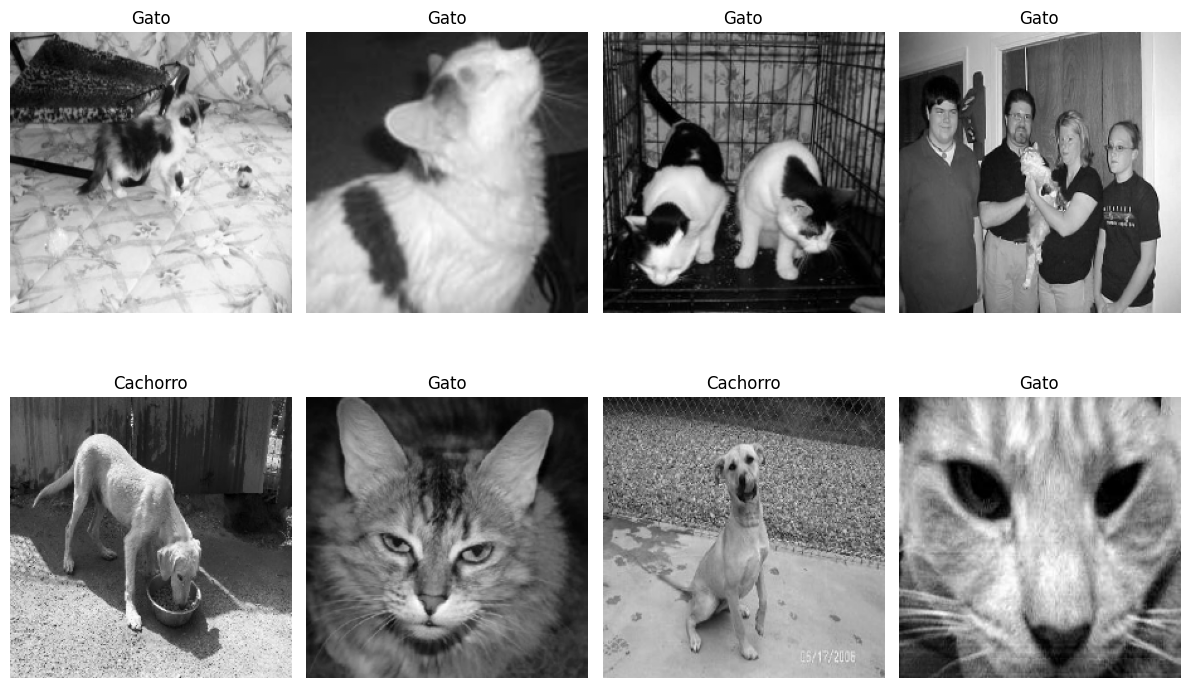

In [50]:
import matplotlib.pyplot as plt

def plot_sample_images(dataset, num_images=8):
    """
    Plots sample images from a tf.data.Dataset.
    """
    plt.figure(figsize=(12, 8))

    # 1. Get one batch of images from the dataset iterator
    images, labels = next(iter(dataset))

    for i in range(min(num_images, len(images))):
        ax = plt.subplot(2, 4, i + 1)

        # 2. Convert tensor to numpy array and set colormap to gray
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')

        class_name = 'Cachorro' if labels[i] == 1 else 'Gato'
        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Now you can call it with your new dataset
print("Exemplos de imagens do dataset:")
plot_sample_images(train_dataset)

CRIAÇÃO DO MODELO COM TRANSFER LEARNING

In [55]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def create_transfer_learning_model():
    """
    Cria modelo usando Transfer Learning com VGG16 adaptado para grayscale
    """
    # Carregar modelo pré-treinado VGG16 (sem as camadas superiores)
    vgg16_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # 2. Freeze the entire VGG16 base. This is the correct way.
    vgg16_base.trainable = False

    # Criar um novo modelo com uma camada de entrada para grayscale
    inp = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # **NEW:** Add rescaling layer for normalization
    x = layers.Rescaling(1./255)(inp)

    # Get a reference to the Conv2D layer
    conv_layer = layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        name='block1_conv1_grayscale'
    )
    x = conv_layer(x)


    # Copiar os pesos da primeira camada convolucional do VGG16
    # e adaptá-los para a entrada em escala de cinza (média dos canais)
    original_weights = vgg16_base.get_layer('block1_conv1').get_weights()
    new_weights = [np.mean(original_weights[0], axis=2, keepdims=True), original_weights[1]]
    # Set the weights on the layer, not the tensor
    conv_layer.set_weights(new_weights)

    # Adicionar as camadas restantes do VGG16
    for layer in vgg16_base.layers[2:]:
        x = layer(x)

    # Adicionar a cabeça de classificação
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Criar o modelo final
    model = keras.Model(inputs=inp, outputs=output)

    return model, vgg16_base

# Criar modelo
model, base_model = create_transfer_learning_model()

# Visualizar arquitetura
model.summary()

print(f"\nNúmero de camadas no modelo base: {len(base_model.layers)}")
print(f"Número de camadas treináveis: {len([layer for layer in model.layers if layer.trainable])}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_11 (Cast)                  │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1_grayscale (Conv2D) │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,779,329 (56.38 MB)

 Trainable params: 66,433 (259.50 KB)

 Non-trainable params: 14,712,896 (56.13 MB)


Número de camadas no modelo base: 19
Número de camadas treináveis: 8


COMPILAÇÃO DO MODELO

In [56]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

CALLBACKS PARA TREINAMENTO

In [57]:
# Early stopping para evitar overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Redução da learning rate quando não há melhoria
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

TREINAMENTO DO MODELO

In [58]:
EPOCHS_PHASE1 = 10

history_phase1 = model.fit(
    train_dataset,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Primeira fase de treinamento concluída!")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.5042 - loss: 0.7740 - val_accuracy: 0.6737 - val_loss: 0.6533 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.5971 - loss: 0.6719 - val_accuracy: 0.7412 - val_loss: 0.5862 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6754 - loss: 0.6059 - val_accuracy: 0.7738 - val_loss: 0.5153 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.7371 - loss: 0.5456 - val_accuracy: 0.8213 - val_loss: 0.4290 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7562 - loss: 0.5049 - val_accuracy: 0.8288 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7836 - loss: 0.4537 - val_accuracy: 0.8487 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.8

FINE-TUNING

In [59]:
# Descongelar algumas camadas do modelo base para fine-tuning
base_model.trainable = True

# Congelar as primeiras camadas, permitir treino apenas das últimas
fine_tune_at = len(base_model.layers) - 4

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompilar com learning rate menor para fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001/10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(f"Camadas treináveis após fine-tuning: {len([layer for layer in model.layers if layer.trainable])}")

# Segunda fase de treinamento
EPOCHS_PHASE2 = 10

print(f"Configuração do fine-tuning:")
print(f"- Épocas fase 2: {EPOCHS_PHASE2}")

Camadas treináveis após fine-tuning: 12
Configuração do fine-tuning:
- Épocas fase 2: 10


In [61]:
print("Iniciando Fine-tuning...")

history_phase2 = model.fit(
    train_dataset,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Iniciando Fine-tuning...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9755 - loss: 0.0690 - val_accuracy: 0.9438 - val_loss: 0.1275 - learning_rate: 2.0000e-06
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9778 - loss: 0.0608 - val_accuracy: 0.9463 - val_loss: 0.1280 - learning_rate: 2.0000e-06
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9778 - loss: 0.0639 - val_accuracy: 0.9450 - val_loss: 0.1293 - learning_rate: 2.0000e-06
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9832 - loss: 0.0549 - val_accuracy: 0.9463 - val_loss: 0.1263 - learning_rate: 2.0000e-06
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.9800 - loss: 0.0579 - val_accuracy: 0.9488 - val_loss: 0.1311 - learning_rate: 2.0000e-06
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.9781 - loss: 0.0551 - val_accuracy: 0.9500 - val_loss: 0.1292 - learning_rate: 2.0000e-06
Epoch 7/10
100/100 ━━

VISUALIZAÇÃO DOS RESULTADOS DE TREINAMENTO

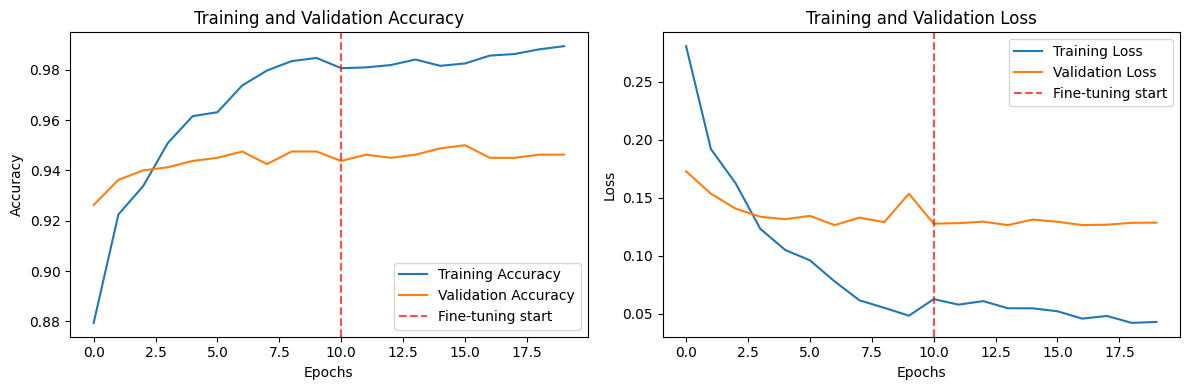

In [62]:
def plot_training_history(history1, history2):
    """
    Plota gráficos de loss e accuracy durante o treinamento
    """
    # Combinar históricos
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning start')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.history['loss']), color='r', linestyle='--', alpha=0.7, label='Fine-tuning start')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, history_phase2)

AVALIAÇÃO DO MODELO

In [64]:
# Avaliação final
test_loss, test_accuracy = model.evaluate(validation_dataset, verbose=0)
print(f"\nAcurácia final no conjunto de validação: {test_accuracy:.4f}")
print(f"Loss final no conjunto de validação: {test_loss:.4f}")


Acurácia final no conjunto de validação: 0.9450
Loss final no conjunto de validação: 0.1263


PREDIÇÕES E MATRIZ DE CONFUSÃO

In [66]:
def evaluate_model_detailed(model, generator):
    """
    Avaliação detalhada do modelo com matriz de confusão
    """
    # Reset do gerador
    generator.reset()

    # Predições
    predictions = model.predict(generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Labels verdadeiros
    true_classes = generator.classes

    # Nomes das classes
    class_names = ['Gatos', 'Cachorros']

    # Relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Matriz de confusão
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predição')
    plt.ylabel('Verdadeiro')
    plt.show()

    return predictions, predicted_classes

predictions, predicted_classes = evaluate_model_detailed(model, validation_dataset)

AttributeError: '_PrefetchDataset' object has no attribute 'reset'

SALVAMENTO DO MODELO

In [69]:
# Salvar o modelo treinado
model.save('cats_vs_dogs_transfer_learning.keras')
print("\nModelo salvo como 'cats_vs_dogs_transfer_learning.keras'")

# Para carregar o modelo posteriormente:
# loaded_model = keras.models.load_model('cats_vs_dogs_transfer_learning.keras')

print("\n" + "="*50)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("="*50)
print(f"Acurácia final: {test_accuracy:.4f}")
print("Modelo salvo e pronto para uso!")


Modelo salvo como 'cats_vs_dogs_transfer_learning.keras'

PROJETO CONCLUÍDO COM SUCESSO!
Acurácia final: 0.9450
Modelo salvo e pronto para uso!
